In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

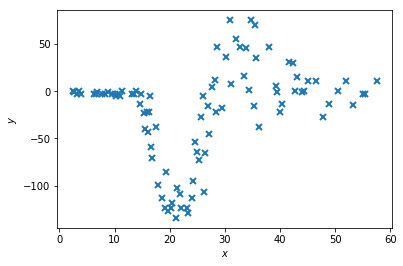

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k = hetero_kernels.RBF(1)
l = hetero_likelihoods.Gaussian()
m = hetero_gpmc.GPMC(Xnorm, Y[:,None], k, l)
m

Name,values,prior,constraint
model.V,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve
model.likelihood.variance,[ 1.],None,+ve


In [4]:
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1.,1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1.,1.)

In [5]:
m.optimize(maxiter=500) # start near MAP
samples = m.sample(5000, verbose=True, epsilon=0.01, thin = 2, burn = 500, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  99.0 %
Iteration:  300 	 Acc Rate:  95.0 %
Iteration:  400 	 Acc Rate:  96.0 %
Iteration:  500 	 Acc Rate:  99.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  95.0 %
Iteration:  500 	 Acc Rate:  99.0 %
Iteration:  600 	 Acc Rate:  98.0 %
Iteration:  700 	 Acc Rate:  96.0 %
Iteration:  800 	 Acc Rate:  97.0 %
Iteration:  900 	 Acc Rate:  97.0 %
Iteration:  1000 	 Acc Rate:  98.0 %
Iteration:  1100 	 Acc Rate:  95.0 %
Iteration:  1200 	 Acc Rate:  96.0 %
Iteration:  1300 	 Acc Rate:  97.0 %
Iteration:  1400 	 Acc Rate:  95.0 %
Iteration:  1500 	 Acc Rate:  98.0 %
Iteration:  1600 	 Acc Rate:  99.0 %
Iteration:  1700 	 Acc Rate:  96.0 %
Iteration:  1800 	 Acc Rate:  98.0 %
Iteration:  1900 	 Acc Rate:  100.0 %
Iteration:  2000 	 Acc Rate:  98.0 %
Iteration:  2100 	 Acc Rate:  96.0 %
Ite

In [6]:
m

Name,values,prior,constraint
model.V,[[ -9.26092778e-02] [ -1.19978094e-01] [ -1.95518531e-01] [ -2.29824427e-01] [ -1.20276392e-01] [ -1.03504387e-02] [ 2.95306349e-01] [ 3.42505970e-01] [ 3.21613750e-01] [ 1.59188390e-01] [ -2.12117514e-01] [ -7.36854227e-01] [ -1.31646396e+00] [ -9.91056399e-01] [ -1.67331445e+00] [ -2.06439084e+00] [ -2.32384836e+00] [ -4.53366854e+00] [ -4.93052335e+00] [ -2.69424054e+00] [ -4.65829010e+00] [ -2.92601963e+00] [ -3.52174713e+00] [ -2.55149309e+00] [ -2.38504787e+00] [ -1.81807938e+00] [ -1.65502230e+00] [ -1.71303282e+00] [ -1.75526596e+00] [ -1.67470753e+00] [ -2.38841591e+00] [ -1.39686802e+00] [ -1.69869213e+00] [ -1.19495750e+00] [ -3.86467401e-01] [ -3.20234176e-01] [ -2.37304631e-01] [ 4.66327964e-02] [ 2.72489856e-01] [ 5.16699409e-01] [ 6.67201269e-01] [ 5.07236514e-01] [ 1.31749926e+00] [ 1.30743513e+00] [ 1.18344059e+00] [ 1.08102172e+00] [ 1.31211793e+00] [ 1.07746275e+00] [ 1.18401248e+00] [ 8.01302444e-01] [ 1.03017389e+00] [ 6.40922590e-01] [ 6.92961302e-01] [ 9.41559259e-01] [ 5.46023567e-01] [ 6.73392154e-01] [ 5.53486559e-01] [ 3.11597658e-01] [ 2.81668785e-01] [ 2.95113218e-01] [ 1.55152040e-01] [ -6.81290531e-03] [ -5.32342286e-02] [ -7.96052832e-02] [ -8.58168072e-02] [ 3.13803163e-03] [ 7.95406613e-02] [ 1.55642275e-01] [ 2.39266162e-01] [ 2.61723667e-01] [ 2.20102100e-01] [ 2.48736525e-01] [ 3.75011870e-01] [ 5.26648390e-01] [ 2.94018847e-01] [ -7.88210346e-02] [ -1.36120656e-01] [ -3.20672590e-01] [ -3.66848624e-01] [ -4.49760226e-01] [ -2.84557698e-01] [ -1.31800527e-01] [ -1.85349795e-01] [ -9.25091075e-02] [ -3.26609538e-02] [ -1.29240665e-02] [ -2.68127857e-02] [ -5.27239746e-02] [ 1.10638747e-02] [ 1.56685874e-01] [ 2.25204375e-01] [ 1.79081570e-01] [ 6.82841009e-02] [ 2.04486839e-02]],"N([ 0.],[ 1.])",(none)
model.kern.lengthscales,[ 0.26188527],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 84.08803144],"Ga([ 1.],[ 1.])",+ve
model.likelihood.variance,[ 123.98540041],"Ga([ 1.],[ 1.])",+ve


In [7]:
sample_df = m.get_samples_df(samples)
like_var_samples = m.likelihood.variance.get_samples_df(samples)

In [8]:
noise_var = np.array([])
for s in like_var_samples:
    noise_var = np.append(noise_var, s)

In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv
meanmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
noisemat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean, v = m.predict_f(xx)
    var = v[:,:]
    meanmat[i,:] = mean[:,0]
    varmat[i,:] = np.diag(var)
    noisemat[i,:] = noise_var[i]

In [12]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Stdgrid = np.sqrt(Vargrid)
    Std_noise = np.sqrt(noise_var)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

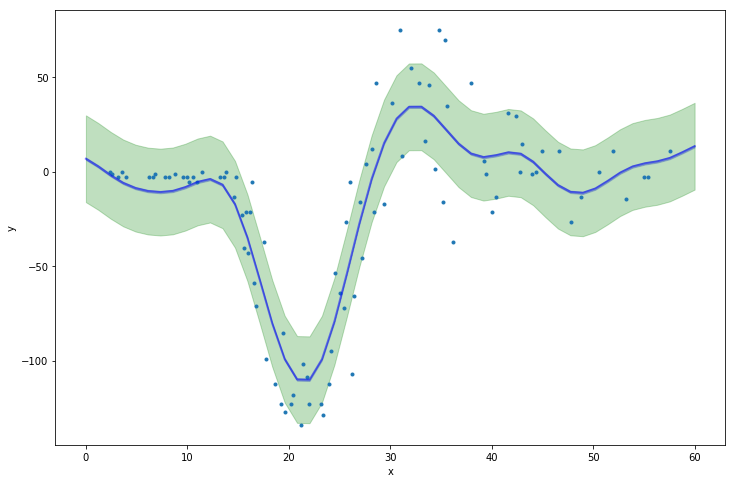

In [13]:
mini = 205
maxi = 206
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, meanmat[i,:], varmat[i,:], noisemat[i,:])

In [ ]:
meanmat[0,:]